# Classifying pediatric IBD stool samples (work in progress)

This notebook is a recoding of the analysis used in the PLoSONE paper: [Non-Invasive Mapping of the Gastrointestinal Microbiota Identifies Children with Inflammatory Bowel Disease](http://www.plosone.org/article/info%3Adoi%2F10.1371%2Fjournal.pone.0039242) using python, sklearn and pandas.

[We](http://almlab.mit.edu) thought that the SLiME package, as it was packaged for the publication of the paper became outdated and should probably not be available anymore. This notebook replaces it, replicating the analysis executed on the paper with more up-to-date tools and with a few extra figures.
I hope this can be the starting point for others trying to follow the same approach and improve upon it. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline

from scipy import interp
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.cross_validation import cross_val_score, StratifiedKFold, train_test_split, KFold
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.preprocessing import LabelEncoder, label_binarize

In [5]:
print('pandas ' + pd.__version__)
print('mpl ' +mpl.__version__)
print('numpy' + np.__version__)
print('seaborn ' + sns.__version__)

pandas 0.17.1
mpl 1.5.0
numpy1.10.2
seaborn 0.7.0


## Loading data
The data came from two rounds of 16S sequencing of previously collected stool samples. Here we will use the OTU tables directly, which were created by using the RDP classifier and were subsequently normalized (details in the paper's methods).

Sequencing was performed at the [Broad Institute](https://www.broadinstitute.org/). The first round of sequencing was dubbed **CHIMP** (Children Hospital IBD Pediatric), while the second round of sequencing -- performed following the request of an anonymous peer reviewer -- was termed *blind validation*. Its purpose was to further validate the algorithm trained on the CHIMP dataset, as one of the reviewers did not think it was sufficient to use a "leave 20% out" approach on the CHIMP dataset to demonstrate robust prediction. 

While these rounds were used as training and test set in the last figure of the paper respectively, it is more useful at this stage to join the two data sets and split them in different random combinations later.

In [6]:
#get the CHIMP training data

X_chimp = pd.read_csv('data/chimp/chimp.Qsorted.rdpout.xtab.norm', delimiter="\t", index_col=0)
y_chimp = pd.read_csv('data/chimp/sampledata.training.chimp.csv', index_col=0)

#just make sure the labels are the same
X_chimp.sort_index(inplace=True)
y_chimp.sort_index(inplace=True)
assert (X_chimp.index == y_chimp.index).all()

In [7]:
## do the same for the blind validation test data
X_blind = pd.read_csv('data/chimp/blind.sorted.rdpout.xtab.norm',
                        delimiter="\t", index_col=0)
y_blind = pd.read_csv('data/chimp/sampledata.validation.blind.csv',
                        index_col=0)

X_blind.sort_index(inplace=True)
y_blind.sort_index(inplace=True)
assert (X_blind.index == y_blind.index).all()

In [8]:
#concatenate using pandas
X = pd.concat([X_chimp, X_blind], keys=['chimp','blind'])
X.head()

cls_Actinobacteria  cls_Alphaproteobacteria  cls_Bacilli  \
chimp 003A            0.000000                 0.000549     0.014827   
      004A            0.000000                 0.000000     0.002486   
      005A            0.006521                 0.000000     0.026084   
      008A            0.000315                 0.000000     0.000210   
      009A            0.001291                 0.000000     0.001550   

            cls_Bacteroidia  cls_Betaproteobacteria  cls_Clostridia  \
chimp 003A         0.002197                0.000275        0.230917   
      004A         0.754195                0.000000        0.230889   
      005A         0.000000                0.000000        0.908706   
      008A         0.837024                0.035995        0.112499   
      009A         0.823864                0.024277        0.118027   

            cls_Cyanobacteria  cls_Deltaproteobacteria  \
chimp 003A                  0                 0.000000   
      004A                  0                 0.000932   
      005A                  0                 0.000000   
      008A                  0                 0.000000   
      009A                  0                 0.000000   

            cls_Epsilonproteobacteria  cls_Erysipelotrichi  \
chimp 003A                          0             0.000000   
      004A                          0             0.001865   
      005A                          0             0.054451   
      008A                          0             0.000840   
      009A                          0             0.000000   

                     ...            phylum_Euryarchaeota  phylum_Firmicutes  \
chimp 003A           ...                               0           0.245744   
      004A           ...                               0           0.238036   
      005A           ...                               0           0.990545   
      008A           ...                               0           0.113758   
      009A           ...                               0           0.119576   

            phylum_Fusobacteria  phylum_Lentisphaerae  phylum_NA  \
chimp 003A             0.023064                     0   0.000000   
      004A             0.000000                     0   0.000000   
      005A             0.000000                     0   0.000326   
      008A             0.000000                     0   0.000000   
      009A             0.000000                     0   0.000000   

            phylum_Proteobacteria  phylum_Spirochaetes  phylum_Synergistetes  \
chimp 003A               0.728995                    0                   NaN   
      004A               0.007147                    0                   NaN   
      005A               0.002608                    0                   NaN   
      008A               0.048903                    0                   NaN   
      009A               0.055269                    0                   NaN   

            phylum_TM7  phylum_Verrucomicrobia  
chimp 003A         NaN                       0  
      004A         NaN                       0  
      005A         NaN                       0  
      008A         NaN                       0  
      009A         NaN                       0  

[5 rows x 284 columns]

In [9]:
X.fillna(value=0,inplace=True) #replace NAs with zeroes

In [10]:
y_dx = pd.concat([y_chimp.dx, y_blind.dx], keys=['chimp','blind'])
print(y_dx.head())
print(y_dx.value_counts())

       sample
chimp  003A      UC
       004A      UC
       005A      NM
       008A      CD
       009A      UC
Name: dx, dtype: object

In [11]:
#convert the training and testing labels to numerical values
le = LabelEncoder()
le.fit(y_dx)
y = le.transform(y_dx)

# just for reference, the columns of the binarized label read respectively:
le.inverse_transform([0,1,2])

array(['CD', 'NM', 'UC'], dtype=object)

## Exploratory data analysis

In [48]:
# map CD,NM and UC to healthy and IBD classes
y_ibd = y_dx.map({'CD':'ibd','UC':'ibd','NM':'healthy'})
y_ibd.value_counts()

ibd        121
healthy     37
Name: dx, dtype: int64

In [49]:
# split OTU by phylogenetic level
expl = X.copy()
expl.columns = expl.columns.str.partition('_')
expl.head()

cls                                            \
                        _                                             
           Actinobacteria Alphaproteobacteria   Bacilli Bacteroidia   
chimp 003A       0.000000            0.000549  0.014827    0.002197   
      004A       0.000000            0.000000  0.002486    0.754195   
      005A       0.006521            0.000000  0.026084    0.000000   
      008A       0.000315            0.000000  0.000210    0.837024   
      009A       0.001291            0.000000  0.001550    0.823864   

                                                                            \
                                                                             
           Betaproteobacteria Clostridia Cyanobacteria Deltaproteobacteria   
chimp 003A           0.000275   0.230917             0            0.000000   
      004A           0.000000   0.230889             0            0.000932   
      005A           0.000000   0.908706             0            0.000000   
      008A           0.035995   0.112499             0            0.000000   
      009A           0.024277   0.118027             0            0.000000   

                                                       ...        \
                                                       ...         
           Epsilonproteobacteria Erysipelotrichi       ...         
chimp 003A                     0        0.000000       ...         
      004A                     0        0.001865       ...         
      005A                     0        0.054451       ...         
      008A                     0        0.000840       ...         
      009A                     0        0.000000       ...         

                  phylum                                                  \
                       _                                                   
           Euryarchaeota Firmicutes Fusobacteria Lentisphaerae        NA   
chimp 003A             0   0.245744     0.023064             0  0.000000   
      004A             0   0.238036     0.000000             0  0.000000   
      005A             0   0.990545     0.000000             0  0.000326   
      008A             0   0.113758     0.000000             0  0.000000   
      009A             0   0.119576     0.000000             0  0.000000   

                                                                          
                                                                          
           Proteobacteria Spirochaetes Synergistetes TM7 Verrucomicrobia  
chimp 003A       0.728995            0             0   0               0  
      004A       0.007147            0             0   0               0  
      005A       0.002608            0             0   0               0  
      008A       0.048903            0             0   0               0  
      009A       0.055269            0             0   0               0  

[5 rows x 284 columns]

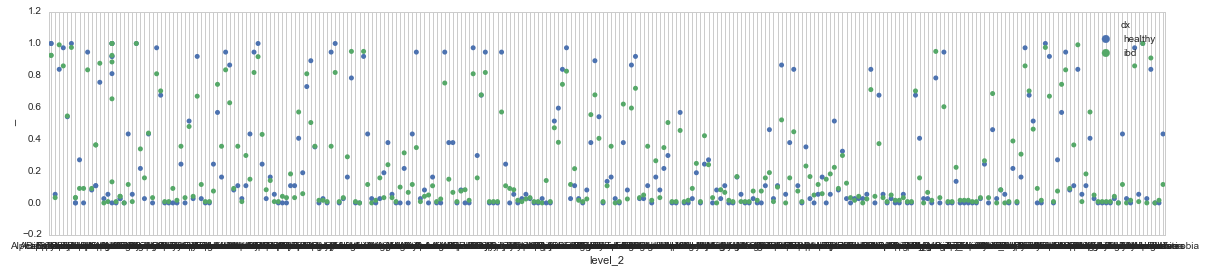

In [155]:
# how many healthy people have a given OTU vs how many IBD patients have the same OTU
# we use the mean, dividing by the total number of patients in each group to get percentages
otupresence = expl.astype(bool).groupby(y_ibd).mean()
otup = otupresence.stack(level=[0,2]).reset_index()
plt.figure(figsize=(20,4))
f = sns.stripplot(data=otup,x='level_2',y='_',hue='dx')
f.axes.xaxis.grid(True)
f.axes.yaxis.grid(False)

In [224]:
ibdotu = otupresence.stack(level=[0,2]).unstack('dx').reset_index()
ibdotu.columns.values
ibdotu.columns=['level','name','healthy','ibd']
ibdotu_abd = ibdotu[(ibdotu.healthy < 0.1) & (ibdotu.ibd > 0.05) & (ibdotu.level != 'domain')]
print('We found %s OTUs (out of %s ~= %1.1f %%) that are \n \
present in IBD (> 5%% of patients) and underrepresented (< 10 %%) in healthy controls\n' % \
      (ibdotu_abd.shape[0],ibdotu.shape[0],(ibdotu_abd.shape[0]/ibdotu.shape[0])*100))
print(ibdotu_abd)

We found 30 OTUs (out of 284 ~= 10.6 %) that are 
 present in IBD (> 5% of patients) and underrepresented (< 10 %) in healthy controls

      level                   name   healthy       ibd
8       cls  Epsilonproteobacteria  0.000000  0.090909
10      cls          Flavobacteria  0.081081  0.090909
24   family          Aerococcaceae  0.027027  0.157025
31   family     Campylobacteraceae  0.000000  0.090909
38   family     Corynebacteriaceae  0.027027  0.115702
46   family      Flavobacteriaceae  0.081081  0.090909
54   family       Leptotrichiaceae  0.027027  0.082645
83    genus            Abiotrophia  0.027027  0.157025
88    genus         Actinobacillus  0.000000  0.099174
90    genus        Aggregatibacter  0.000000  0.066116
103   genus        Asaccharobacter  0.081081  0.074380
104   genus              Atopobium  0.000000  0.082645
115   genus          Campylobacter  0.000000  0.090909
116   genus         Capnocytophaga  0.054054  0.082645
124   genus            Citrobacter  0.0

In [ ]:
# let's make it easier to see.
#multiply ibd percentages by -1
otup.loc[otup['dx'] == 'ibd',"_"] *= -1

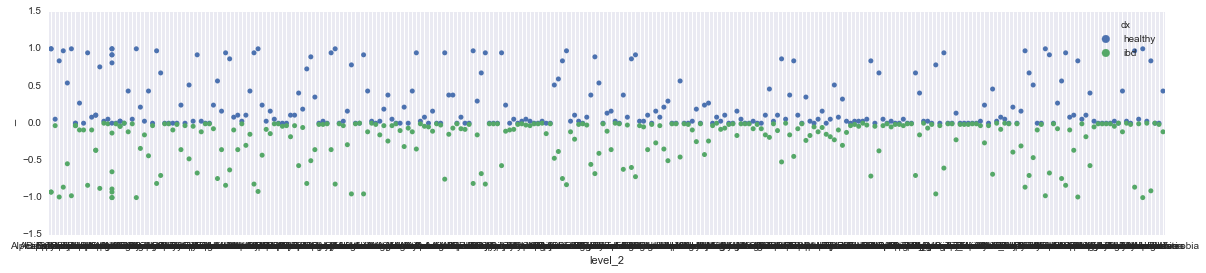

In [130]:
plt.figure(figsize=(20,4))
f = sns.stripplot(data=otup,x='level_2',y='_',hue='dx')
f.axes.xaxis.grid(True)
f.axes.yaxis.grid(False)

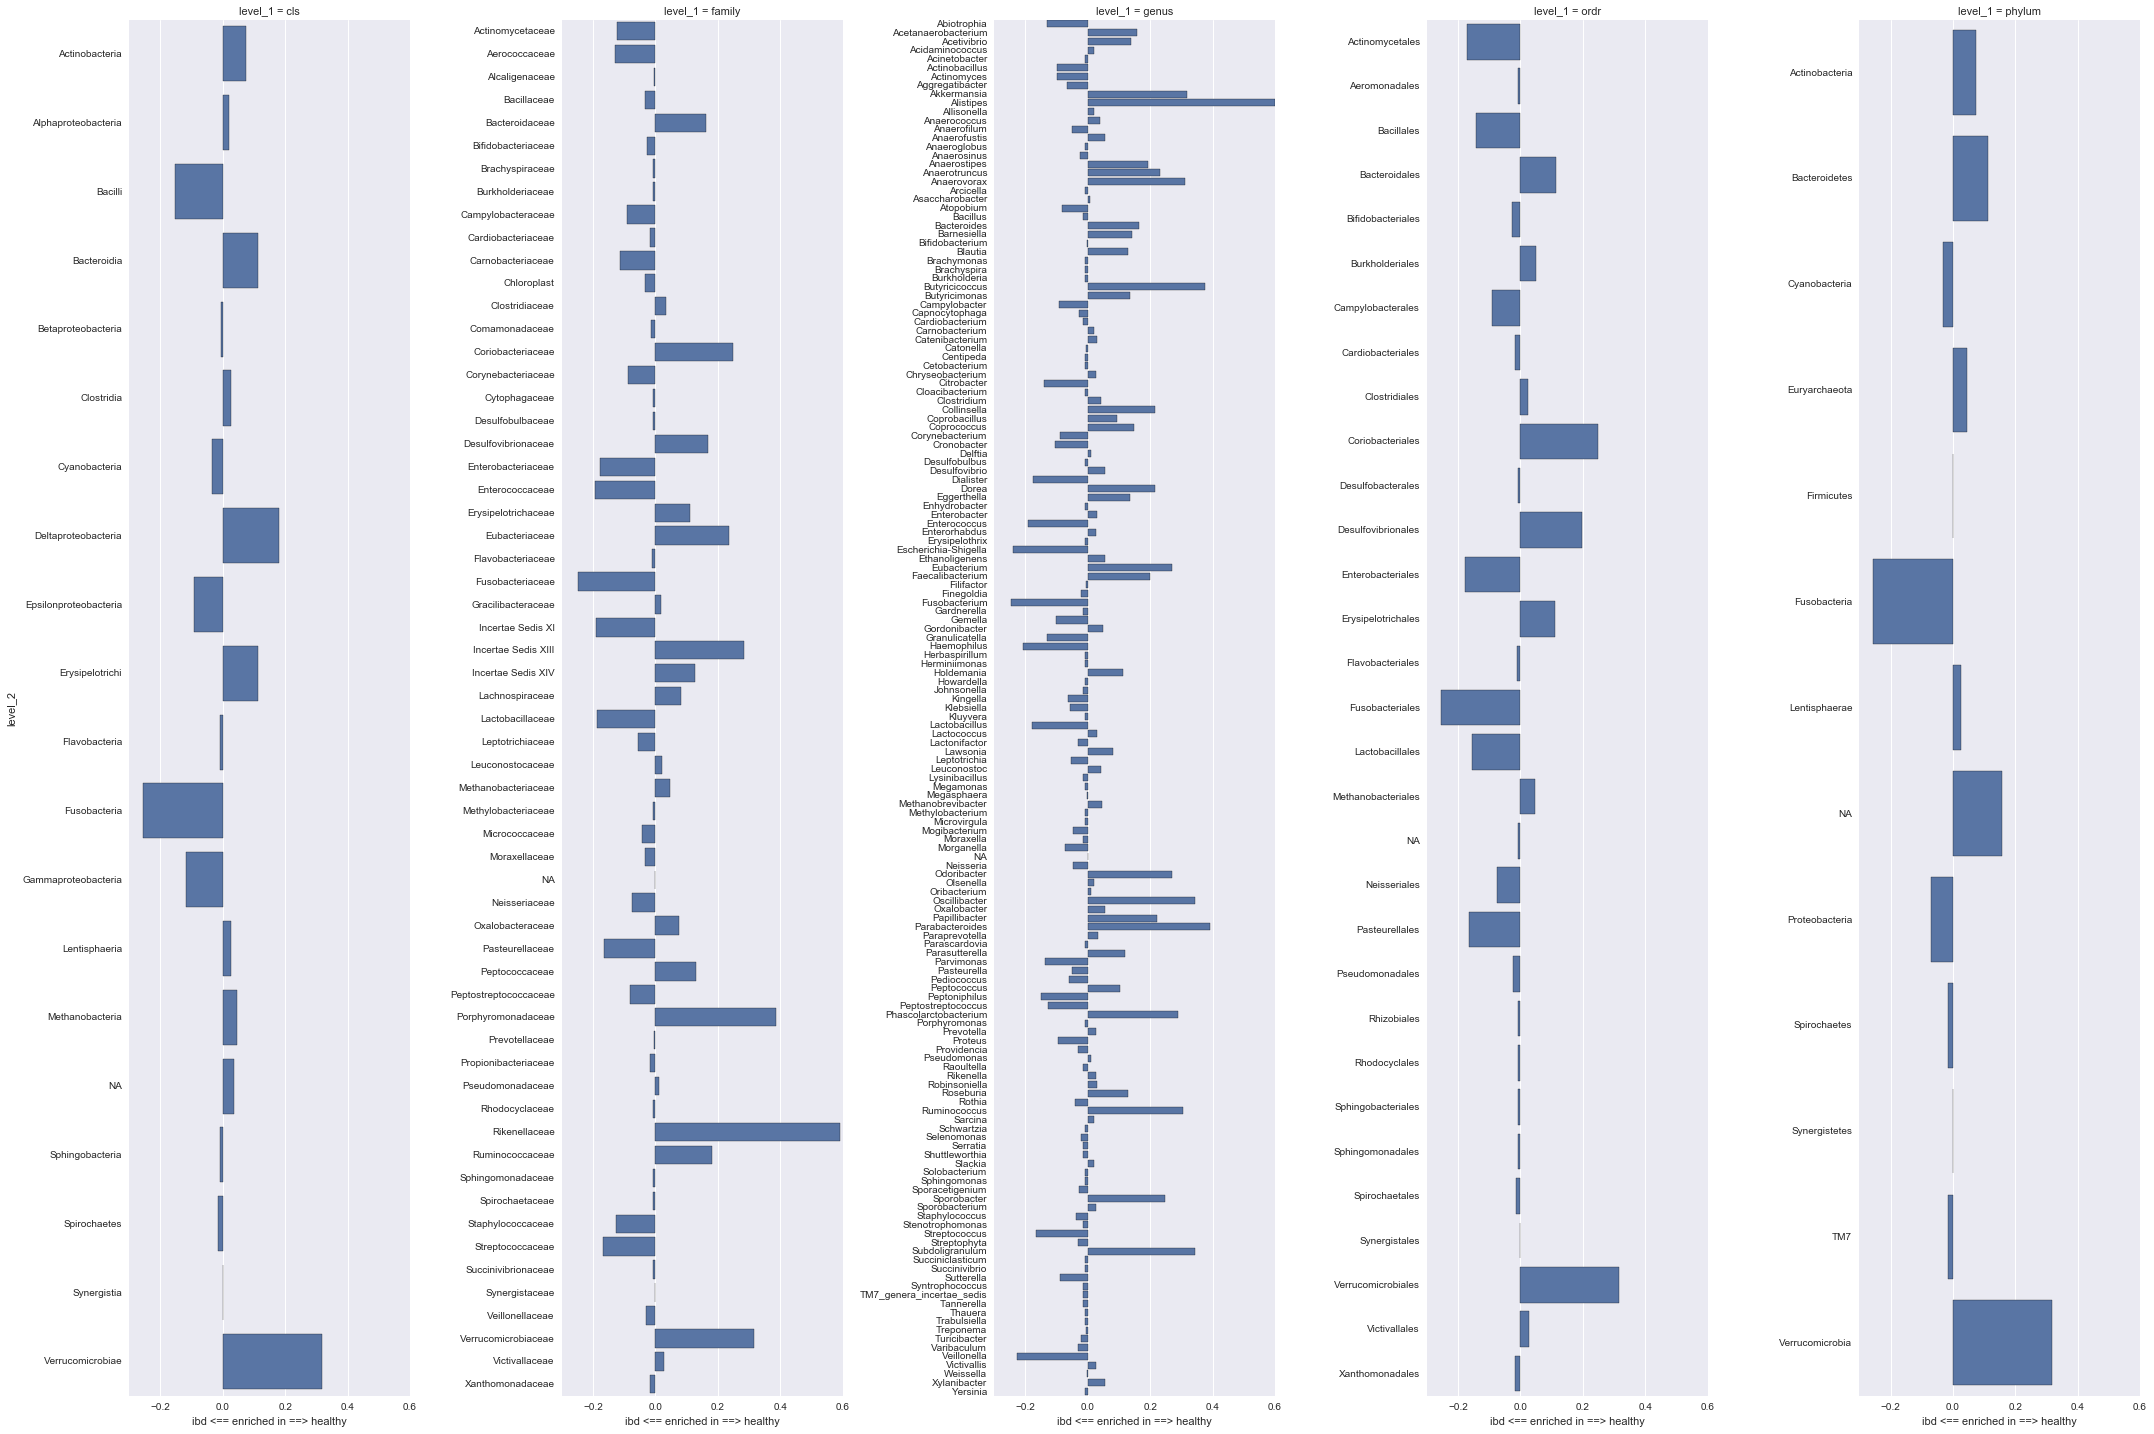

In [131]:
diff = otup.groupby(['level_1','level_2']).sum().reset_index()
diff.head()
g = sns.FacetGrid(diff[diff.level_1 != 'domain'], col="level_1",sharey=False,size=20, aspect=.3)
g.map(sns.barplot,"_","level_2")
g.set_xlabels('ibd <== enriched in ==> healthy')

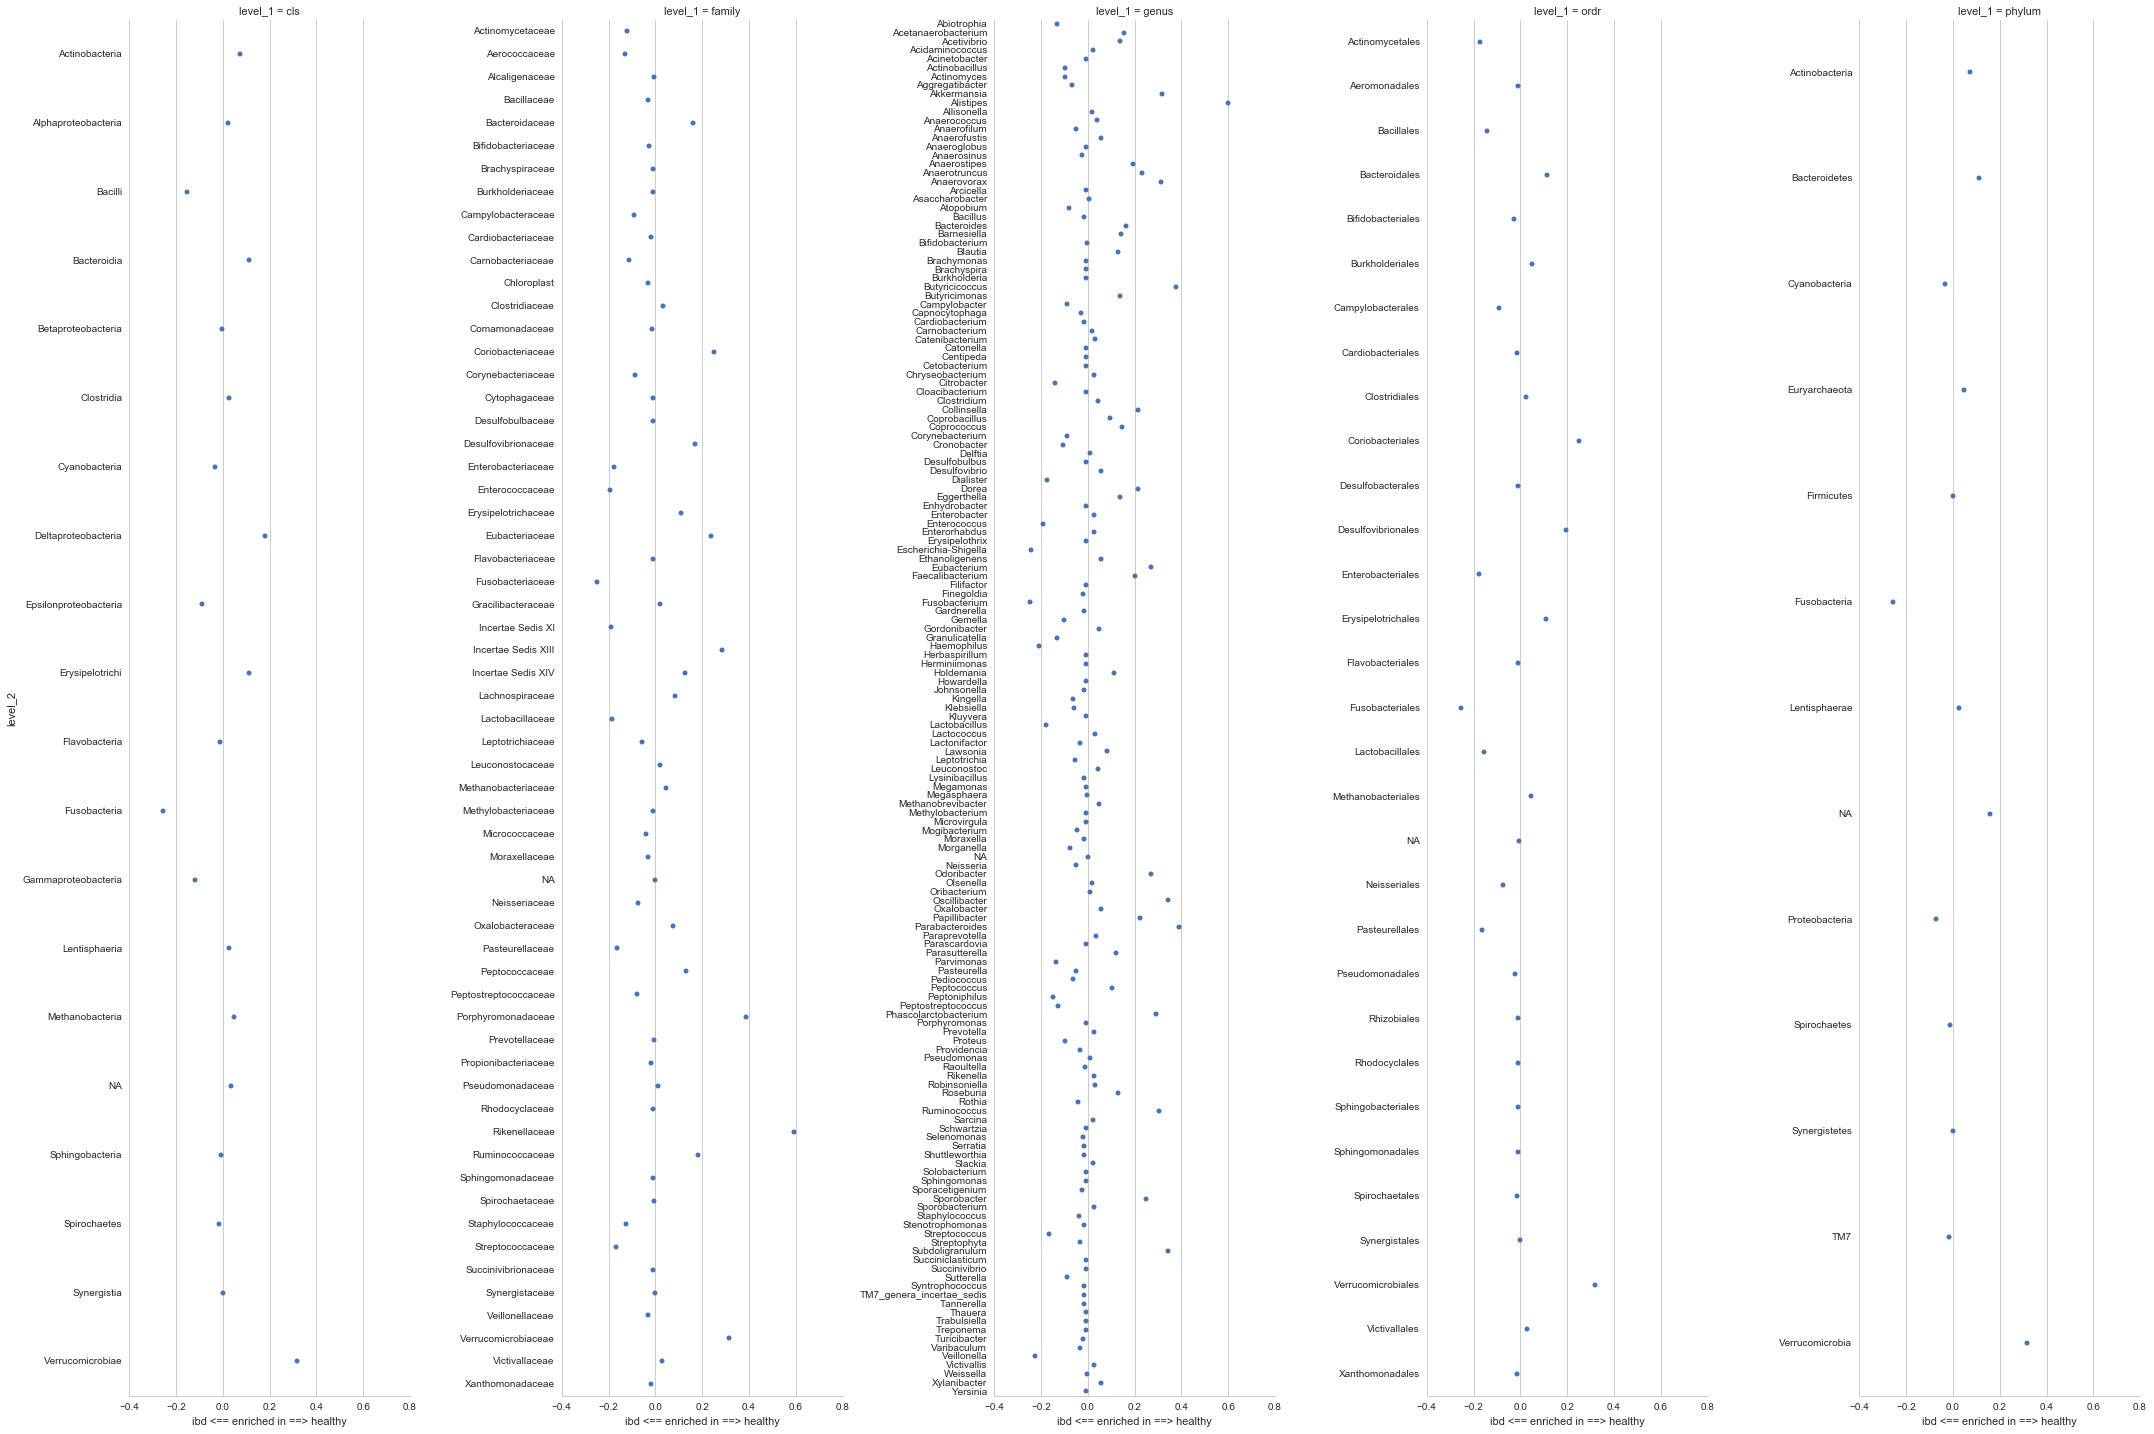

In [135]:
sns.set_style("whitegrid")
g = sns.FacetGrid(diff[diff.level_1 != 'domain'], col="level_1",sharey=False,size=20, aspect=.3)
g.map(sns.stripplot,"_","level_2")
g.set_xlabels('ibd <== enriched in ==> healthy')

for ax in g.axes.flat:
    # Make the grid horizontal instead of vertical
#     ax.xaxis.grid(False)
    ax.yaxis.grid(True)

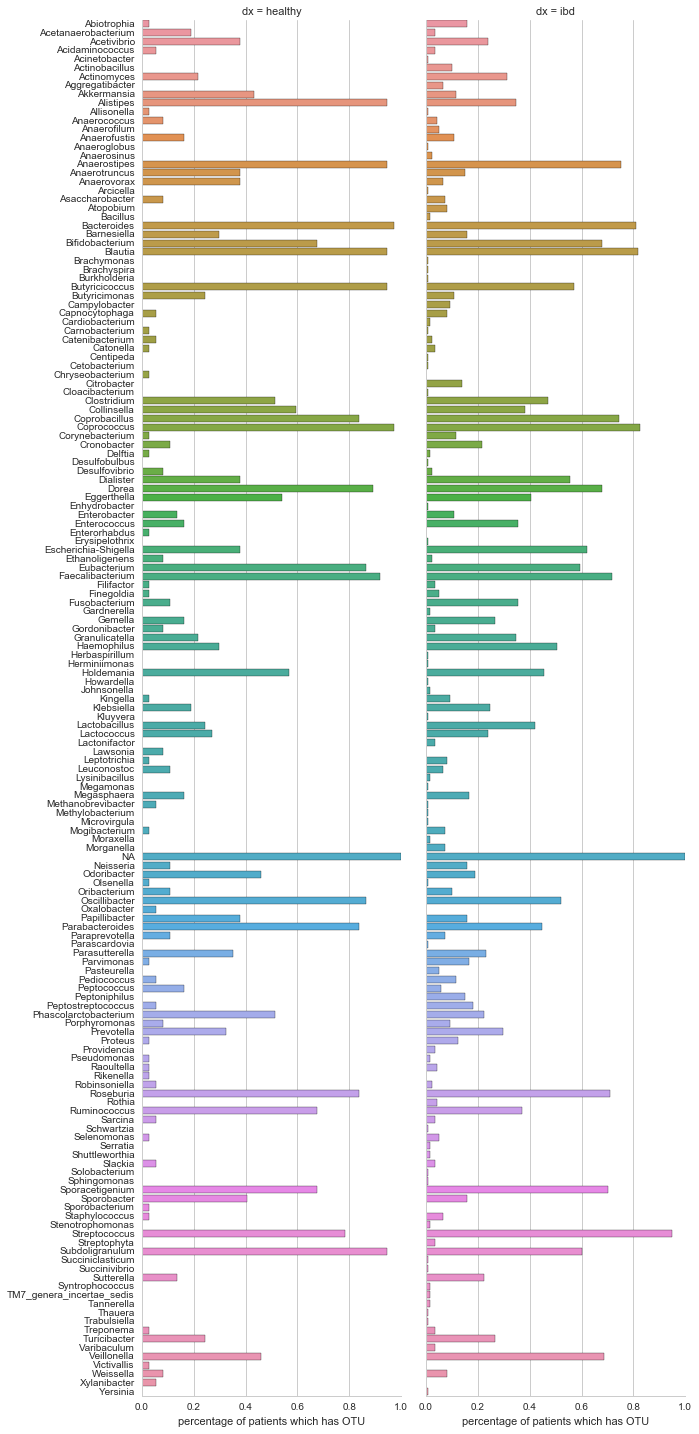

In [229]:
f = sns.factorplot(x='_',y='level_2',col='dx',data=otup[otup.level_1 == 'genus'],kind='bar',size=20,aspect=.25)
f.set_axis_labels('percentage of patients which has OTU',"")
plt.savefig('OTUs.png')

## Label classification
*Please note that the ROC plots will look different everytime the notebook is run due to the random nature of the cross-validation split*

### Vanilla classifier
We will go straight to using RandomForest and a 10-fold cross validation. Many other models were tried but RandomForest consistently prevented overfitting. First let's get an idea of how it looks like when you try to classify all the labels at the same time. 

In [30]:
clf = RandomForestClassifier(n_estimators=50, oob_score=True)
clf.fit(X.values, y)
scores = cross_val_score(clf, X.values, y, cv=10)

print("Cross validation score:")
print(scores.mean())

importances = clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in clf.estimators_],axis = 0)
indices = np.argsort(importances)[::-1]

print("feature ranking:")

for f in range(20):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Cross validation score:
0.567471988796
feature ranking:
1. feature 71 (0.030080)
2. feature 92 (0.029311)
3. feature 52 (0.021462)
4. feature 223 (0.019596)
5. feature 12 (0.018157)
6. feature 66 (0.017697)
7. feature 45 (0.017373)
8. feature 145 (0.016363)
9. feature 216 (0.015820)
10. feature 79 (0.015636)
11. feature 65 (0.014432)
12. feature 99 (0.014312)
13. feature 109 (0.014086)
14. feature 72 (0.014012)
15. feature 51 (0.013417)
16. feature 37 (0.013062)
17. feature 27 (0.013053)
18. feature 2 (0.012811)
19. feature 0 (0.012587)
20. feature 272 (0.012439)


### Build a One-vs-all ROC curve (not cross validated)
To build a ROC curve we need to binarize the variable and run the classifier as one class vs. all others

In [31]:
y_bin = label_binarize(y,classes=[0,1,2])
n_classes = y_bin.shape[1]

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y_bin, test_size=.3)

In [33]:
clf1 = OneVsRestClassifier(RandomForestClassifier(n_estimators=50))
y_score = clf1.fit(X_train, y_train).predict_proba(X_test)

/usr/local/lib/python3.4/site-packages/sklearn/utils/__init__.py:93: DeprecationWarning: Function multilabel_ is deprecated; Attribute multilabel_ is deprecated and will be removed in 0.17. Use 'y_type_.startswith('multilabel')' instead
  warnings.warn(msg, category=DeprecationWarning)


The probabilities of each class are now in a numpy array where each row corresponds to sample and each column to the label in question (CD, NM or UC). Let's take a pick at the first 10:

In [34]:
y_score[:10,:]

array([[ 0.48,  0.1 ,  0.34],
       [ 0.56,  0.08,  0.56],
       [ 0.02,  0.74,  0.14],
       [ 0.32,  0.16,  0.58],
       [ 0.16,  0.4 ,  0.58],
       [ 0.28,  0.02,  0.76],
       [ 0.34,  0.42,  0.34],
       [ 0.48,  0.06,  0.58],
       [ 0.3 ,  0.08,  0.48],
       [ 0.28,  0.64,  0.2 ]])

In [35]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = roc_auc_score(y_test[:,i], y_score[:,i],average="micro")

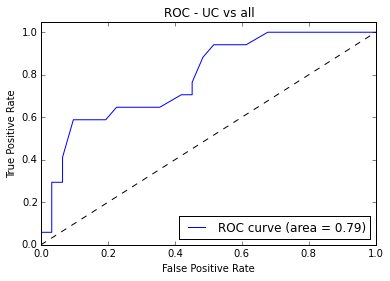

In [36]:
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr[2], tpr[2], label='ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - UC vs all')
plt.legend(loc="lower right")
plt.show()

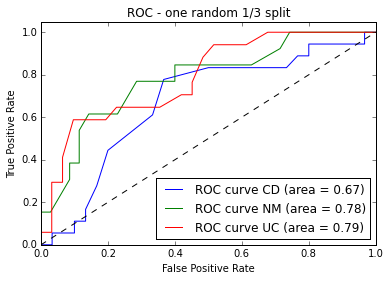

In [37]:
# Plot ROC curves all together now
plt.figure()

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label='ROC curve {0} (area = {1:0.2f})'
                                   ''.format(le.inverse_transform(i), roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - one random 1/3 split')
plt.legend(loc="lower right")
plt.show()

### ROC cross validated [Figure 6A](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0039242#pone-0039242-g006)
#### top panel: one vs all

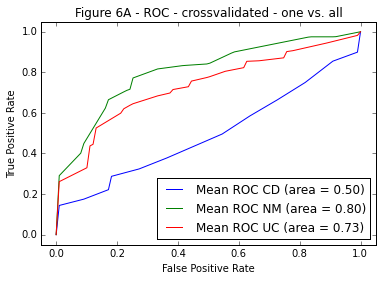

In [38]:
# Run classifier with cross-validation and plot ROC curves

for dx in range(n_classes):
    cv = StratifiedKFold(y_bin[:,dx], n_folds=10)
    classifier = RandomForestClassifier()

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (train, test) in enumerate(cv):
        probas_ = classifier.fit(X.iloc[train], y_bin[train,dx]).predict_proba(X.iloc[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y_bin[test,dx], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        #plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))


    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 
             label='Mean ROC %s (area = %0.2f)' % (le.inverse_transform(dx), mean_auc), lw=1)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 6A - ROC - crossvalidated - one vs. all')
plt.legend(loc="lower right")
plt.show()

#### bottom panel: CD vs UC

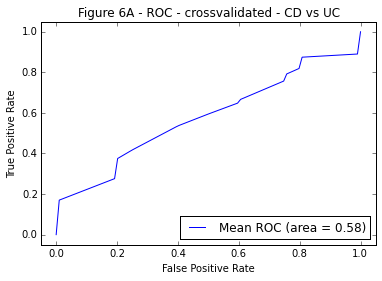

In [39]:
# Only CD vs UC

X_cduc = X[(y == 0) | (y == 2)]
y_cduc = y[(y == 0) | (y == 2)]
np.place(y_cduc,y_cduc == 2, 1)

cv = StratifiedKFold(y_cduc, n_folds=10)
clf_cduc = RandomForestClassifier()

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

for i, (train, test) in enumerate(cv):
    fitted = classifier.fit(X_cduc.iloc[train], y_cduc[train])
    probas_ = fitted.predict_proba(X_cduc.iloc[test])
    scored_ = fitted.predict(X_cduc.iloc[test])
    # Compute ROC curve and area the curve
    fpr, tpr, thresholds = roc_curve(y_cduc[test], probas_[:, 1])
    mean_tpr += interp(mean_fpr, fpr, tpr)
    mean_tpr[0] = 0.0
    #roc_auc = auc(fpr, tpr)
    roc_auc = roc_auc_score(scored_, y_cduc[test], average="micro")
    #plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))


mean_tpr /= len(cv)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
plt.plot(mean_fpr, mean_tpr, 
         label='Mean ROC (area = %0.2f)' % mean_auc, lw=1)

plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Figure 6A - ROC - crossvalidated - CD vs UC')
plt.legend(loc="lower right")
plt.show()

## Comparison with the Frank et al. dataset
The [original paper](http://www.pnas.org/content/104/34/13780.full) links to the available dataset. As outlined in the paper, the SLiME pipeline runs RDP on the fasta files and outputs a matrix of normalized abundance of each family, class, genus, etc. 

I am going to load directly that table, which has had the ibd classification label appended to it.

In [40]:
frank = pd.read_csv('data/pace/pace.rdpout.xtab.norm.ibd.csv')
frank_label = frank['ibd']
del frank['ibd']
frank_label = (frank_label == 'yes')
frank_label.value_counts()

True     129
False     61
dtype: int64

### Figure 1A

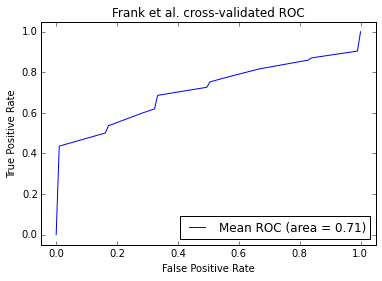

In [48]:
def crossval_roc(X, y):
    cv = StratifiedKFold(y, n_folds=10)
    clf = RandomForestClassifier()

    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []

    for i, (train, test) in enumerate(cv):
        fitted = clf.fit(X[train], y[train])
        probas_ = fitted.predict_proba(X[test])
        scored_ = fitted.predict(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        #roc_auc = auc(fpr, tpr)
        roc_auc = roc_auc_score(scored_, y[test], average="micro")
        #plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))


    mean_tpr /= len(cv)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 
                    label='Mean ROC (area = %0.2f)' % mean_auc, lw=1)
    plt.legend(loc="lower right")
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

fig = crossval_roc(frank.values,frank_label.values)
plt.title('Frank et al. cross-validated ROC')
plt.show()

### Figure 1B

ROC curve for SLiME classification of active IBD patients vs controls in the pediatric case-control data set.

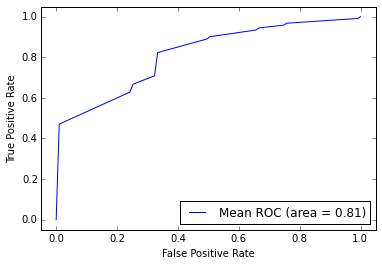

In [52]:
y_isibd = (y != 1)
crossval_roc(X.values, y_isibd)

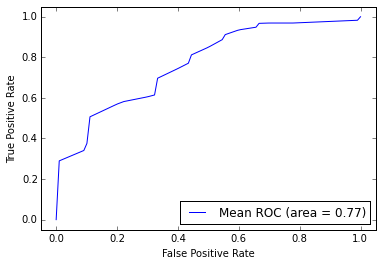

In [67]:
y_blind['active'] = (y_blind.activity == 'Mild') | (y_blind.activity == 'Severe') | (y_blind.activity == 'Moderate')
y_active = pd.concat([y_chimp.active == 'active', y_blind.active], keys =['chimp','blind'])
crossval_roc(X.values,y_active)

In [ ]:
# TODO : find the best features based on KW test + FDR/qval adjustment
# look into https://github.com/thomas-haslwanter/statsintro/blob/master/Code3/KruskalWallis.py
#http://statsmodels.sourceforge.net/devel/generated/statsmodels.sandbox.stats.multicomp.multipletests.html
# http://docs.scipy.org/doc/scipy-0.13.0/reference/generated/scipy.stats.mstats.kruskalwallis.html
